In [1]:
import requests, json
from datetime import datetime, timedelta
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shapely
import networkx as nx

In [2]:
PROJECTION=32630

#### Station ridership

In [3]:
counts_en = pd.read_csv('/Users/itto/Documents/cities/data/london/counts/En17week_mod.csv', skiprows=6).set_index(' Station')
counts_ex = pd.read_csv('/Users/itto/Documents/cities/data/london/counts/Ex17week.csv', skiprows=6).set_index(' Station')

# We only care about the time columns
time_columns = counts_en.columns[4:-8]

# Easier to work with stations as columns, so transpose
data_en = counts_en.loc[:, time_columns].T
data_ex = counts_ex.loc[:, time_columns].T

# Remove "Total" column
data_en.drop('Total',axis=1,inplace=True)
data_ex.drop('Total',axis=1,inplace=True)

# Extract the first time
data_en.index = data_en.index.str[:4]
data_ex.index = data_en.index.str[:4]

# Convert to datetime format
data_en.index = pd.to_datetime(data_en.index, format='%H%M')
data_ex.index = pd.to_datetime(data_en.index, format='%H%M')

# Create a time of day index that we can use from now on
time_of_day_map = {
    6: 'morning',
    7: 'morning',
    8: 'morning',
    9: 'morning',
    10: 'off',
    11: 'off',
    12: 'off',
    13: 'off',
    14: 'off',
    15: 'off',
    16: 'afternoon',
    17: 'afternoon',
    18: 'afternoon',
    19: 'afternoon'
}
time_of_day = data_en.index.hour.map(time_of_day_map).to_series()
time_of_day[time_of_day.isnull()] = 'night'
time_of_day = time_of_day.values

In [4]:
# Get the entrances and exists for each time interval
entrances = data_en.groupby(time_of_day).sum().T
exits = data_ex.groupby(time_of_day).sum().T

In [5]:
entrances['total'] = entrances.afternoon + entrances.night + entrances.off + entrances.morning
entrances['morning_max'] = data_en.loc[time_of_day == 'morning'].max()
entrances['afternoon_max'] = data_en.loc[time_of_day == 'afternoon'].max()
entrances['off_mean'] = data_en.loc[time_of_day == 'off'].mean()

In [6]:
station_geom = gpd.read_file('../data/london/shapes/stations/stations_mod.shp')
# Change to UTM
station_geom.to_crs(epsg=PROJECTION, inplace=True)
# Remove the word "Station"
station_geom.columns = station_geom.columns.str.lower()
station_geom.rename(columns={'geometry':'location'}, inplace=True)
station_geom.name = station_geom.name.str.replace('\t','').str.replace('\n','').str.replace(' Station','')
station_geom.set_index('name', drop=True, inplace=True)

# Read Voronoi cells
station_voronoi = gpd.read_file('../data/london/shapes/stations/voronoi.shp')
station_voronoi.to_crs(epsg=PROJECTION, inplace=True)
station_voronoi.columns = station_voronoi.columns.str.lower()
station_voronoi.rename(columns={'geometry':'cell'}, inplace=True)
station_voronoi.name = station_voronoi.name.str.replace('\t','').str.replace('\n','').str.replace(' Station','')
station_voronoi.set_index('name', drop=True, inplace=True)

# Combine Voronoi with location
station_geom['cell'] = station_voronoi.reindex(station_geom.index).cell


#### Combine the data

In [7]:
# Combine entrances and station locations data
stations = pd.merge(station_geom, entrances, left_index=True, right_index=True)
stations['station'] = stations.index

#### Network

In [8]:
nodes = pd.read_csv('../data/london/network/nodes.csv')
nodes['geometry'] = [shapely.geometry.Point(p) for p in list(zip(nodes.longitude.values, nodes.latitude.values))]
nodes = gpd.GeoDataFrame(nodes)
nodes.crs = {'init' :'epsg:4326'}
nodes.to_crs(epsg= PROJECTION, inplace=True)

In [9]:
node_map = nodes.set_index('id')['geometry'].to_dict()

In [10]:
lines = pd.read_csv('../data/london/network/lines.csv')
lines['point1'] = lines.station1.map(node_map)
lines['point2'] = lines.station2.map(node_map)
lines = gpd.GeoDataFrame(lines)
lines.crs = nodes.crs

In [11]:
lines['geometry'] = ([shapely.geometry.LineString([p1,p2]) for (p1,p2) in lines[['point1','point2']].values])

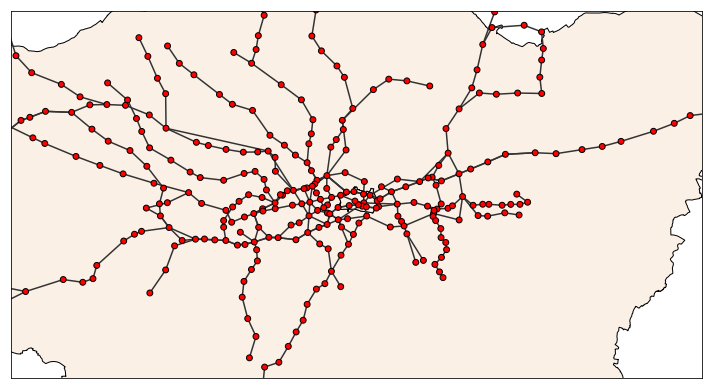

In [12]:
shp_london = gpd.read_file('../data/london/shapes/misc/london.shp')

f,(ax1) = plt.subplots(1,1, figsize=(10,10))
shp_london.plot(ax=ax1,color='linen',edgecolor='k',zorder=0)
lines.plot(ax=ax1, color=[0.2,0.2,0.2], zorder=1)
nodes.buffer(200).plot(ax=ax1, edgecolor='k', color='r')

ax1.set_xlim((678000,725000))
ax1.set_ylim((5699000,5724000))
ax1.set_xticks([])
ax1.set_yticks([])

f.tight_layout(w_pad=2)

### Extract the hotspots

In [180]:
residents = (stations.morning - stations.off_mean*4*2)
residents[residents < 0] = 0
# residents -= residents.min()
workers = (stations.afternoon - stations.off_mean*4*2)
workers[workers < 0] = 0

In [181]:
def loubar(resource):
    x = range(resource.shape[0])
    y = (resource.sort_values()/resource.sum()).cumsum().values
    tangent_slope = (y[-1] - y[-2])/(x[-1] - x[-2])
    tangent_zero = x[-1] - y[-1]/tangent_slope  
    hotspots = resource.sort_values().iloc[x[np.ceil(tangent_zero).astype(int):]].index
    
    return hotspots, (x,y,tangent_slope, tangent_zero)

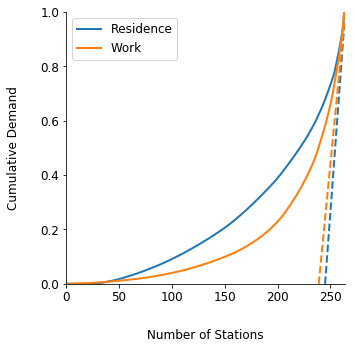

In [182]:
f,ax = plt.subplots(1,1, figsize=(5,5))

hotspots_res,(x,y,tangent_slope,tangent_zero) = loubar(residents)
ax.plot(y, 'C0',lw=2)
ax.plot([tangent_zero, y.shape[0]], [0, y[-1]], 'C0', ls='dashed', lw=2, label='_nolegend_')

hotspots_work,(x,y,tangent_slope,tangent_zero) = loubar(workers)
ax.plot(y, 'C1',lw=2)
ax.plot([tangent_zero, y.shape[0]], [0, y[-1]], 'C1', ls='dashed', lw=2, label='_nolegend_')

ax.legend(['Residence','Work'])
ax.set_xlabel('Number of Stations',labelpad=25, fontdict={'fontsize':12})
ax.set_ylabel('Cumulative Demand',labelpad=20, fontdict={'fontsize':12})


ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.margins(0)

plt.rcParams.update({'font.size': 12})

In [183]:
hotspots_res = stations.reindex(hotspots_res)
hotspots_work = stations.reindex(hotspots_work)

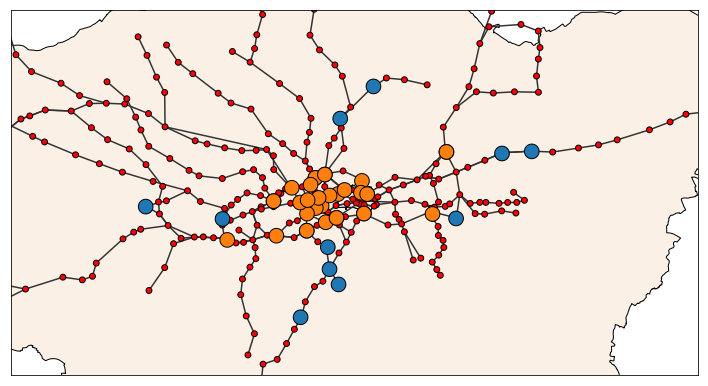

In [217]:
shp_london = gpd.read_file('../data/london/shapes/misc/london.shp')

f,(ax1) = plt.subplots(1,1, figsize=(10,10))
shp_london.plot(ax=ax1,color='linen',edgecolor='k',zorder=0)
lines.plot(ax=ax1, color=[0.2,0.2,0.2], zorder=1)
nodes.buffer(200).plot(ax=ax1, edgecolor='k', color='r')

hotspots_res.set_geometry('location').buffer(500).plot(ax=ax1, edgecolor='k',color='C0')
hotspots_work.set_geometry('location').buffer(500).plot(ax=ax1, edgecolor='k', color='C1')

ax1.set_xlim((678000,725000))
ax1.set_ylim((5699000,5724000))
ax1.set_xticks([])
ax1.set_yticks([])

f.tight_layout(w_pad=2)

### Create network of hotspots

In [185]:
hotspots = pd.concat([hotspots_res, hotspots_work])
hotspots = hotspots[~hotspots.index.duplicated()]

In [713]:
order_rows = residents.reindex(hotspots.index).sort_values().index
order_columns = workers.reindex(hotspots.index).sort_values().index

In [761]:
df = pd.DataFrame(index = order_rows, columns = order_columns)

In [769]:
df.loc[:,:] = 0

In [776]:
for i in hotspots_res.index:
    for j in hotspots_work.index:
        df.loc[i,j] = 1
        df.loc[j,i] = 1

In [777]:
network = nx.from_pandas_adjacency(df).to_undirected()

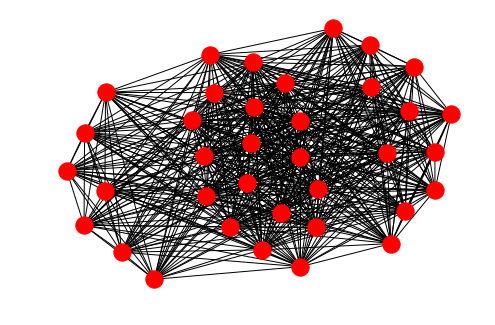

In [780]:
nx.draw(network)

### Estimate the flows from Residence to Home

In [685]:
oyster = pd.read_csv('/Users/itto/Downloads/Nov09JnyExport.csv')

In [692]:
oyster.StartStn = oyster.StartStn.str.lower()
oyster.EndStation = oyster.EndStation.str.lower()

In [693]:
oyster.StartStn = oyster.StartStn.str.replace(' rd',' road')
oyster.EndStation = oyster.EndStation.str.replace(' rd',' road')

In [720]:
df.index = df.index.str.lower()
df.columns = df.columns.str.lower()

In [695]:
od = oyster.loc[~oyster.daytype.isin(['Sat','Sun'])]
od = od.loc[~od.EndStation.isin(['Unfinished','unfinished'])]
od = od.loc[~od.StartStn.isin(['bus'])]

od_morning = od.loc[(od.EntTime >= 360) & (od.EntTime <= 600)]
od_morning = od_morning.groupby(['StartStn','EndStation']).size()
# od_morning = od_morning/od_morning.sum(level=0)

od_afternoon = od.loc[(od.EntTime >= 960) & (od.EntTime <= 1200)]
od_afternoon = od_afternoon.groupby(['StartStn','EndStation']).size()
# od_afternoon = od_afternoon/od_afternoon.sum(level=0)

In [721]:
df.loc[:,:] = 0
df_morning = df.copy()
df_afternoon = df.T.copy()

In [722]:
for (origin,destination),n in od_morning.iteritems():
    # Exclude self-trips
    if origin != destination:
        # Check if this is a hotspot trip
        if (origin in df.index) and (destination in df.columns):
            # Assign the value
            df_morning.loc[origin, destination] = n

In [723]:
for (origin,destination),n in od_afternoon.iteritems():
    # Exclude self-trips
    if origin != destination:
        # Check if this is a hotspot trip
        if (origin in df.index) and (destination in df.columns):
            # Assign the value
            df_afternoon.loc[origin, destination] = n

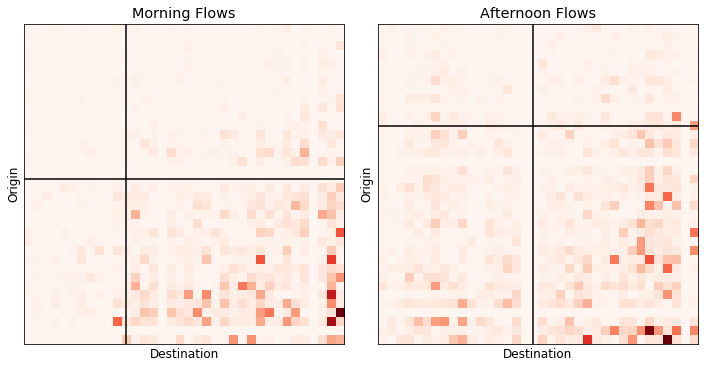

In [726]:
f,(ax1,ax2) = plt.subplots(1,2, figsize = (10,10))
ax1.imshow(df_morning, cmap='Reds')
ax1.axhline(df_morning.shape[0] - hotspots_res.shape[0], c='k')
ax1.axvline(df_morning.shape[1] - hotspots_work.shape[0], c='k')
ax1.set_ylabel('Origin')
ax1.set_yticks([])
ax1.set_xlabel('Destination')
ax1.set_xticks([])
ax1.set_title('Morning Flows')
ax2.imshow(df_afternoon, cmap='Reds')
ax2.axhline(df_afternoon.shape[0] - hotspots_work.shape[0], c='k')
ax2.axvline(df_afternoon.shape[1] - hotspots_res.shape[0], c='k')
ax2.set_ylabel('Origin')
ax2.set_yticks([])
ax2.set_xlabel('Destination')
ax2.set_xticks([])
ax2.set_title('Afternoon Flows')
f.tight_layout()

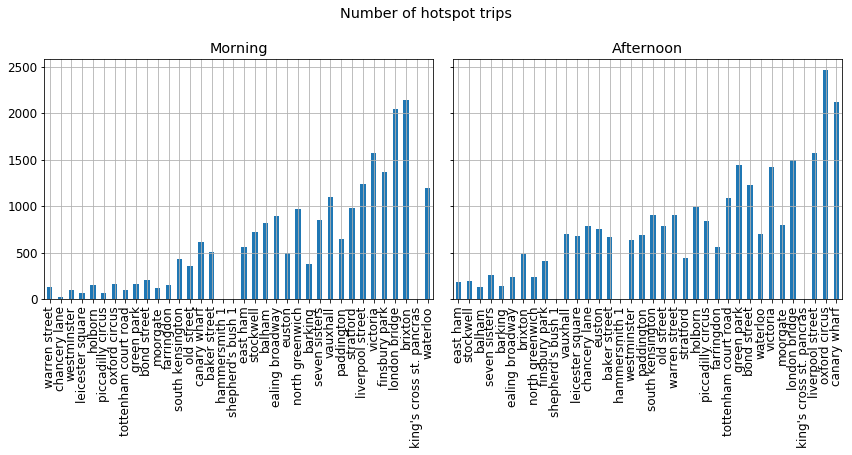

In [986]:
f,(ax1,ax2) = plt.subplots(1,2, figsize = (12,6), sharey=True)
df_morning.sum(axis=1).plot(kind='bar', color='C0', ax=ax1)
ax1.set_title('Morning')
df_afternoon.sum(axis=1).plot(kind='bar', color='C0', ax=ax2)
ax2.set_title('Afternoon')
f.tight_layout()
f.suptitle('Number of hotspot trips', y=1.05)
ax1.grid()
ax2.grid()

## Time analysis

In [843]:
def get_routes(depart_time, pairs, names):
    url = 'https://api.tripgo.com/v1/'
    
    headers = {
    'Accept': 'application/json',
    'X-TripGo-Key': '5c1a480843464d538b24939c266be8b9',
    }
    
    segments = []
    routes = []
    errors = []
    for i,pair in enumerate(pairs):
        try:
            print('Routing: from {} to {}'.format(names[i][0], names[i][1]))
            p2 = pair[0]
            p1 = pair[1]
            direction = i%2 # 0 for To and 1 for Return
            # Set up request
            params = (
                ('from', str(p2)),
                ('to', str(p1)),
                ('modes', 'pt_pub'),
                ('v', '11'),
                ('locale', 'en'),
                ('departAfter', depart_time - 1) #Subtract 1 since it's actually "depart after"
            )

            # Make request
            response = requests.get('https://api.tripgo.com/v1/routing.json', headers=headers, params=params)

            routing = json.loads(response.text)
            segs = pd.DataFrame(routing['segmentTemplates'])
            segs['route'] = int(i/2)
            segs['direction'] = direction
            segs['routeA'] = names[i][0]
            segs['routeB'] = names[i][1]
            segments.append(segs)

            # For all groups
            for j,group in enumerate(routing['groups']):
                df = pd.DataFrame(group['trips'])
                # Meta data
                df['route'] = int(i/2)
                df['direction'] = direction
                df['routeA'] = names[i][0]
                df['routeB'] = names[i][1]
                df['group'] = j
                df['num_segments'] = df.segments.apply(len)
                # Preliminary processing
                df['length'] = (df.arrive - df.depart)/60
                df['depart_time'] = df.depart.apply(datetime.fromtimestamp)
                df['arrive_time'] = df.arrive.apply(datetime.fromtimestamp)
                # Check if it's a completely underground route
                providers = ''
                for source in routing['groups'][j]['sources']:
                    name = source['provider']['name']
                    if ('Underground' not in name) and ('OpenStreetMap' not in name) and ('London Overground' not in name):
                        if len(providers):
                            providers += ', '
                        providers += name
                df['other_providers'] = providers
                routes.append(df)
        except Exception as e:
            print('Could no complete: {} to {}'.format(names[i][0],names[i][1]))
            print('Reason: ',e)
            errors.append(names[i])
            pass
    print('Complete.')
    return routes

In [844]:
# Prepare a list of Res-Work pairs
from itertools import permutations, combinations
# Coordinates
coords_a = hotspots_res.set_geometry('location').to_crs(epsg=4326).geometry
coords_b = hotspots_work.set_geometry('location').to_crs(epsg=4326).geometry
# Create table of coordinates
pairs = []
names = []
adj = nx.to_pandas_adjacency(network)
for nameA, pA in coords_a.iteritems():
    for nameB, pB in coords_b.iteritems():
        if nameA != nameB:
            pairs.append(((pA.y,pA.x),(pB.y,pB.x)))
            names.append((nameA, nameB))

In [846]:
time = datetime(2018,12,5,8,0).timestamp()

In [847]:
%%time

routes = get_routes(int(time),pairs,names)

Routing: from Shepherd's Bush 1 to Leicester Square
Routing: from Shepherd's Bush 1 to Chancery Lane
Routing: from Shepherd's Bush 1 to Euston
Routing: from Shepherd's Bush 1 to Baker Street
Routing: from Shepherd's Bush 1 to Hammersmith 1
Routing: from Shepherd's Bush 1 to Westminster
Routing: from Shepherd's Bush 1 to Paddington
Routing: from Shepherd's Bush 1 to South Kensington
Routing: from Shepherd's Bush 1 to Old Street
Routing: from Shepherd's Bush 1 to Warren Street
Routing: from Shepherd's Bush 1 to Stratford
Routing: from Shepherd's Bush 1 to Holborn
Routing: from Shepherd's Bush 1 to Piccadilly Circus
Routing: from Shepherd's Bush 1 to Farringdon
Routing: from Shepherd's Bush 1 to Tottenham Court Road
Routing: from Shepherd's Bush 1 to Green Park
Routing: from Shepherd's Bush 1 to Bond Street
Routing: from Shepherd's Bush 1 to Waterloo
Routing: from Shepherd's Bush 1 to Victoria
Routing: from Shepherd's Bush 1 to Moorgate
Routing: from Shepherd's Bush 1 to London Bridge
Rou

Routing: from Barking to King's Cross St. Pancras
Routing: from Barking to Liverpool Street
Routing: from Barking to Oxford Circus
Routing: from Barking to Canary Wharf
Routing: from Seven Sisters to Leicester Square
Routing: from Seven Sisters to Chancery Lane
Routing: from Seven Sisters to Euston
Routing: from Seven Sisters to Baker Street
Routing: from Seven Sisters to Hammersmith 1
Routing: from Seven Sisters to Westminster
Routing: from Seven Sisters to Paddington
Routing: from Seven Sisters to South Kensington
Routing: from Seven Sisters to Old Street
Routing: from Seven Sisters to Warren Street
Routing: from Seven Sisters to Stratford
Routing: from Seven Sisters to Holborn
Routing: from Seven Sisters to Piccadilly Circus
Routing: from Seven Sisters to Farringdon
Routing: from Seven Sisters to Tottenham Court Road
Routing: from Seven Sisters to Green Park
Routing: from Seven Sisters to Bond Street
Routing: from Seven Sisters to Waterloo
Routing: from Seven Sisters to Victoria
Rou

Routing: from London Bridge to Old Street
Routing: from London Bridge to Warren Street
Routing: from London Bridge to Stratford
Routing: from London Bridge to Holborn
Routing: from London Bridge to Piccadilly Circus
Routing: from London Bridge to Farringdon
Routing: from London Bridge to Tottenham Court Road
Routing: from London Bridge to Green Park
Routing: from London Bridge to Bond Street
Routing: from London Bridge to Waterloo
Routing: from London Bridge to Victoria
Routing: from London Bridge to Moorgate
Routing: from London Bridge to London Bridge
Could no complete: London Bridge to London Bridge
Reason:  'segmentTemplates'
Routing: from London Bridge to King's Cross St. Pancras
Routing: from London Bridge to Liverpool Street
Routing: from London Bridge to Oxford Circus
Routing: from London Bridge to Canary Wharf
Routing: from Brixton to Leicester Square
Routing: from Brixton to Chancery Lane
Routing: from Brixton to Euston
Routing: from Brixton to Baker Street
Routing: from Brix

In [849]:
df_routes = pd.concat(routes)

In [911]:
timestr = datetime.now().strftime('%Y%m%d_%H%M%S')
df_routes.to_csv('./output/routes_'+timestr+'.csv')

In [872]:
od_times = df_routes.groupby(['routeA','routeB']).length.mean().unstack()
od_times = od_times.reindex(residents.reindex(hotspots_res.index).sort_values().index)
od_times = od_times.T.reindex(workers.reindex(hotspots_work.index).sort_values().index)
od_times = od_times.T

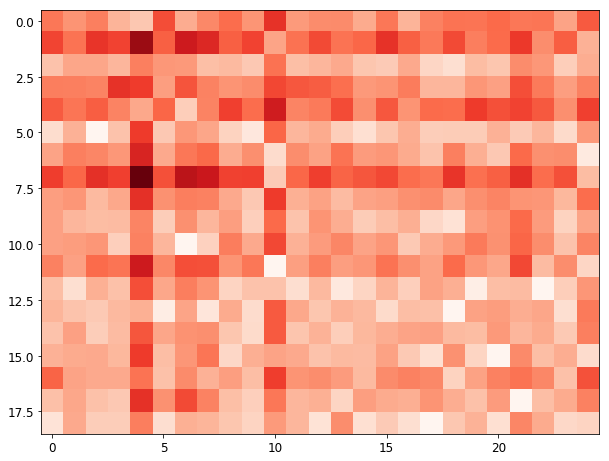

In [993]:
f,ax = plt.subplots(1,1,figsize=(10,10))
ax.imshow(od_times.fillna(0), cmap='Reds')

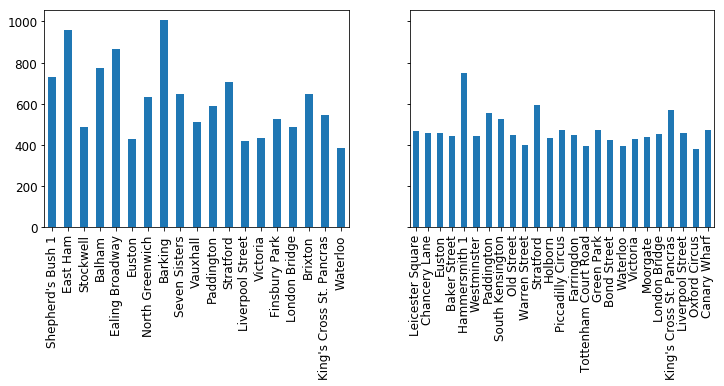

In [1006]:
f,(ax1,ax2) = plt.subplots(1,2,figsize=(12,4), sharey=True)
od_times.sum(axis=1).plot(ax=ax1,kind='bar',color='C0')
od_times.sum(axis=0).plot(ax=ax2,kind='bar',color='C0')

## Combine Time and Ridership

In [989]:
od_riders = df_morning.copy()
od_riders = od_riders.reindex(residents.reindex(hotspots_res.index).sort_values().index.str.lower())
od_riders = od_riders.T.reindex(workers.reindex(hotspots_work.index).sort_values().index.str.lower())
od_riders = od_riders.T

Text(0.5,1,'Route Efficiency (person*hours)')

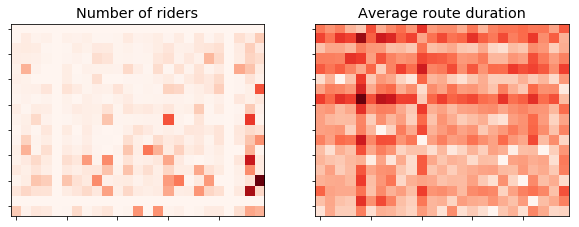

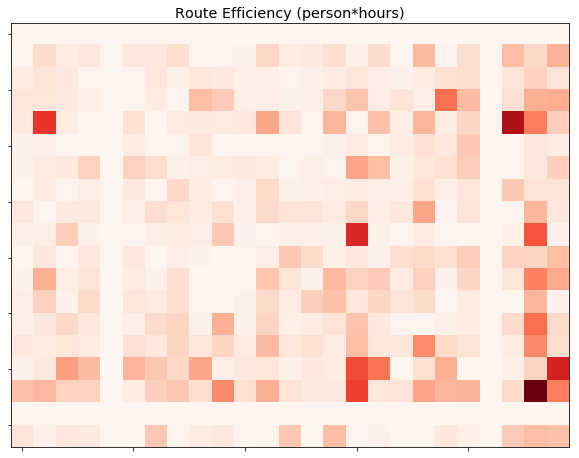

In [1004]:
f,(ax1,ax2) = plt.subplots(1,2,figsize=(10,4), sharey=True)
ax1.imshow(od_riders.fillna(0),cmap='Reds', vmin=od_riders.min().min(), vmax=od_riders.max().max())
ax1.set_yticklabels([])
ax1.set_xticklabels([])
ax1.set_title('Number of riders')
ax2.imshow(od_times.fillna(0), cmap='Reds')
ax2.set_xticklabels([])
ax2.set_yticklabels([])
ax2.set_title('Average route duration')
f,ax1 = plt.subplots(1,1,figsize=(10,8))
performance = od_riders.mul(od_times.values)
ax1.imshow(performance.fillna(0), cmap='Reds')
ax1.set_yticklabels([])
ax1.set_xticklabels([]);
ax1.set_title('Route Efficiency (person*minutes)')

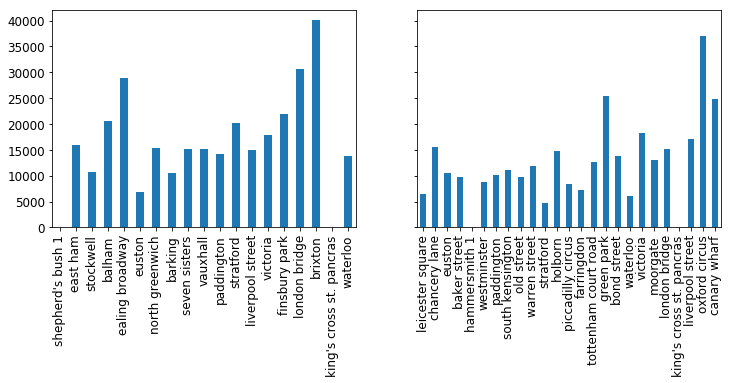

In [1007]:
f,(ax1,ax2) = plt.subplots(1,2,figsize=(12,4), sharey=True)
performance.sum(axis=1).plot(ax=ax1,kind='bar',color='C0')
performance.sum(axis=0).plot(ax=ax2,kind='bar',color='C0')